# Analysis of the COVID19 spread across countries

Descriptive statistical analysis of the cases and deaths realted to the COVID19 desease in 2020.

Data is taken from the European Center for Diseas Control (ECDC).
Thy are not too reliabel on the format so there might be adjustement to make in downloading and reading from day to day.

For the comunulative distributsion we shall implement our own database and format, so that once the data are loaded the analysis is consistent and shall not be updated.

Start by setting the data please

In [1]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

## Download the latest dataset

If you don't have the DB file or want to update it, run the cells below.

They changed format of the files and field names 4-5 times since I started tracking it.
Quite bad attitude towards the users if I may say.

Anyhow, as of today (27-03-2020) they are updating in CVS already. 
With Panda you can kind of always find a way to parse it.

Just be careful with the encoding: countries names may have non-utf8 letters that would crash the parser.

In [2]:
from urllib import request, parse
print("Today is", today)
# url =  "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx" % today
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
req =  request.Request(url) #, data=data) # this will make the method "POST"
resp = request.urlopen(req)
outfile = "ECDC-%s.cvs" % today
with open(outfile, 'wb') as out_cvs:
    out_cvs.write(resp.read())

Today is 2020-03-29


## Parse the dataset

For legacy reasons, I'm storing the CVS with cvs module, but we need to go thorugh Panda for parsing.

Would be better to just use panda throught the notebook.
But I'm doing this for fun so I don't have much time to invest in it.

In [3]:
import pandas as pd        
data_cvs = pd.read_csv(outfile, encoding='mac_roman')
data_cvs.to_csv(outfile)
import csv, json
data = {}
with open(outfile, 'r') as indat:
    csv_reader = csv.DictReader(indat)
    for i, rows in enumerate(csv_reader):
        data[i] = rows     

Check the format of the dataset.
In case some keys changed.

In [4]:
print(data[0])

OrderedDict([('', '0'), ('dateRep', '29/03/2020'), ('day', '29'), ('month', '3'), ('year', '2020'), ('cases', '15'), ('deaths', '1'), ('countriesAndTerritories', 'Afghanistan'), ('geoId', 'AF'), ('countryterritoryCode', 'AFG'), ('popData2018', '37172386.0')])


Convert the dates in days from the first entry.

It's quite handy that it starts at 31-12-2019 for back-converting.

In [5]:
d0 = 1e30
date_strfrm = '%d/%m/%Y' # '%Y/%m/%d' # '%m/%d/%Y' Stupid American date format...
for d in data.values():
    dtime = datetime.strptime(d['dateRep'], date_strfrm).timetuple()
    if dtime.tm_yday+(dtime.tm_year-2019)*365 < d0:
        d0 = dtime.tm_yday+(dtime.tm_year-2019)*365

length = -1e30    
for d in data.values():
    dtime = datetime.strptime(d['dateRep'], date_strfrm).timetuple()
    d['t'] = dtime.tm_yday-d0+(dtime.tm_year-2019)*365
    if d['t'] > length:
        length = d['t']

print("Days from first relevation in DB:", length)

Days from first relevation in DB: 89


### Convert dataset to TinyDB database

Since I want to learn how to use this thing (and also to save it on the disk in case we need it later), put the data in a TinyDB dataset (https://tinydb.readthedocs.io/en/latest/) (version 3.15.2)

In [6]:
from tinydb import TinyDB, Query
covid19_db = TinyDB("covid19_db.json")

# Instance a query object that will help up look up data later.
db_q = Query()

If you don't have the DB and want to build, run the thing below

In [7]:
covid19_db.purge_tables() # Clean the database to put new data in. Be sure you want to do this!
# Upload all data
covid19_db.insert_multiple(data.values())
# Check status
print("DB status", covid19_db)
# Handy to check the spell of all the countries
print("Names:")
for e in sorted(set([e['countriesAndTerritories'] for e in covid19_db.all()])):
    print(e) 


DB status <TinyDB tables=['_default'], tables_count=1, default_table_documents_count=7515, all_tables_documents_count=['_default=7515']>
Names:
Afghanistan
Albania
Algeria
Andorra
Angola
Anguilla
Antigua_and_Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bosnia_and_Herzegovina
Brazil
British_Virgin_Islands
Brunei_Darussalam
Bulgaria
Burkina_Faso
Cambodia
Cameroon
Canada
Cape_Verde
Cases_on_an_international_conveyance_Japan
Cayman_Islands
Central_African_Republic
Chad
Chile
China
Colombia
Congo
Costa_Rica
Cote_dIvoire
Croatia
Cuba
CuraÁao
Cyprus
Czech_Republic
Democratic_Republic_of_the_Congo
Denmark
Djibouti
Dominica
Dominican_Republic
Ecuador
Egypt
El_Salvador
Equatorial_Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Faroe_Islands
Fiji
Finland
France
French_Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guam
Guatemala
Guernsey
Guinea
Guinea_Bissau
Guyana
Hai

Just to check that everything works, print the latest data (head of array) from Italy (or whatever country name you provide)

In [8]:
for i in covid19_db.search(db_q['countriesAndTerritories'] == 'Italy')[:5]:
    print(i['dateRep'], i['cases'], i['deaths'])

29/03/2020 5974 887
28/03/2020 5959 971
27/03/2020 6153 660
26/03/2020 5210 685
25/03/2020 5249 743


## Build cumulative distributions

The original dataset has the new cases per day.
For statistical description of the epidemics, is better to look at the cumulative number of cases through the year.

We store them in a separate database so that you only need to modify the parsing of th ECDC one and not the actual data analysis.

In [9]:
import numpy as np
countries_cumul_tab = covid19_db.table("countries_cumul")

# Thresholds to align the distributions
cc_thold = 200
ccn_thold = 5e-5
cd_thold = 20
cdn_thold = 0.8e-6 

If you don't have the table in the DB and want to build, run the thing below

In [10]:
countries_cumul_tab.purge()
country_cumol_list = []

# Loop over the country names
for country in sorted(set([e['countriesAndTerritories'] for e in covid19_db.all()])):
    t_ch = [] # Time series
    c_ch = [] # Cases
    d_ch = [] # Deaths
    
    print("On ", country)
    
    # Try to get the population form the database. If the data is not there, just set to one.
    try:
        # Any match will do.
        pop = float(covid19_db.search(db_q['countriesAndTerritories'] == country)[0]['popData2018'])
    except ValueError as e:
        print("Teste di cazz...", e)
        pop = 1
        
    # Loop over all the entries (days) of the country and store the new cases
    for i in covid19_db.search(db_q['countriesAndTerritories']  == country):
        t_ch.append(int(i['t']))
        c_ch.append(float(i['cases']))
        d_ch.append(float(i['deaths']))

    # Convert to numpy array
    t_ch = np.array(t_ch)
    # Entries might not be ordered. Get the array of indices sorting the time series.
    t_ord = np.unravel_index(np.argsort(t_ch), t_ch.shape)
    
    # Build the cumulative counts object
    country_cumol = {}
    country_cumol['name'] = country
    country_cumol['pop'] = pop
    # All array need to be ordered
    country_cumol['t'] = np.array(t_ch)[t_ord]
    country_cumol['cc'] = np.add.accumulate(np.array(c_ch)[t_ord])
    country_cumol['cd'] = np.add.accumulate(np.array(d_ch)[t_ord])
    # Normalize per population
    country_cumol['ccn'] = country_cumol['cc']/pop
    country_cumol['cdn'] = country_cumol['cd']/pop
    # Just set a default for the dealy, will compute later
    country_cumol['delay_cc'] = 0
    country_cumol['delay_cd'] = 0
    country_cumol['delay_ccn'] = 0
    country_cumol['delay_cdn'] = 0
    # Uppend to the list 
    country_cumol_list.append(country_cumol)

# Populate the database. Numpy array non-JSON-serializable: convert to list.
# So very annoying.
countries_cumul_tab.insert_multiple([{k: v.tolist() if isinstance(v, np.ndarray) else v 
                                      for k, v in d.items()}
                                      for d in country_cumol_list
                                    ]
                                   )

print("Cumul db status:", countries_cumul_tab)

On  Afghanistan
On  Albania
On  Algeria
On  Andorra
On  Angola
On  Anguilla
Teste di cazz... could not convert string to float: 
On  Antigua_and_Barbuda
On  Argentina
On  Armenia
On  Aruba
On  Australia
On  Austria
On  Azerbaijan
On  Bahamas
On  Bahrain
On  Bangladesh
On  Barbados
On  Belarus
On  Belgium
On  Belize
On  Benin
On  Bermuda
On  Bhutan
On  Bolivia
On  Bosnia_and_Herzegovina
On  Brazil
On  British_Virgin_Islands
On  Brunei_Darussalam
On  Bulgaria
On  Burkina_Faso
On  Cambodia
On  Cameroon
On  Canada
On  Cape_Verde
On  Cases_on_an_international_conveyance_Japan
On  Cayman_Islands
On  Central_African_Republic
On  Chad
On  Chile
On  China
On  Colombia
On  Congo
On  Costa_Rica
On  Cote_dIvoire
On  Croatia
On  Cuba
On  CuraÁao
On  Cyprus
On  Czech_Republic
On  Democratic_Republic_of_the_Congo
On  Denmark
On  Djibouti
On  Dominica
On  Dominican_Republic
On  Ecuador
On  Egypt
On  El_Salvador
On  Equatorial_Guinea
On  Eritrea
Teste di cazz... could not convert string to float: 
On  

### Compute delay time

The epidemics is starting at different time. To do meaninful comparisons, you need to adjust the starting point.
Each quantity needs its own normalization.

Fairly arbitrary. Play around.

In [11]:
from datetime import date


for c in countries_cumul_tab.all():
    print(c['name'])
    
    # Stop looking once you define one delay
    delay_flag = False
    delayd_flag = False
    delayn_flag = False
    delaynd_flag = False
    
    for d, cc, cd in zip(c['t'], c['cc'], c['cd']):
        # Find delay for cases
        if cc >= cc_thold and not delay_flag:
            c['delay_cc'] = d
            # Might be problms converting ordinal to date. China I'm looking at you.
            try: delay_date = date.fromordinal(d).strftime('%d-%m')+'-2020'
            except: pass
            delay_flag = True
            print("cases:  %3i (%3i)" % (d, cc), delay_date, end=" ")
        
        # Find delay for deaths
        if cd >= cd_thold and not delayd_flag:
            c['delay_cd'] = d
            try: delay_date = date.fromordinal(d).strftime('%d-%m')+'-2020'
            except: pass            
            print("death: %3i (%3i)" % (d, cd), delay_date, end=" ")
            delayd_flag = True
            
        # Find delay for cases normalized by population
        if cc >= ccn_thold*c['pop'] and not delayn_flag:
            c['delay_ccn'] = d
            try: delay_date = date.fromordinal(d).strftime('%d-%m')+'-2020'
            except: pass
            print("case/pop: %3i (%3i, %5.3e)" % (d, cc, cc/pop), delay_date, end=" ")
            delayn_flag = True
            
        # Find delay for deaths normalized by population
        if cd >= cdn_thold*c['pop'] and not delaynd_flag:
            c['delay_cdn'] = d
            try: delay_date = date.fromordinal(d).strftime('%d-%m')+'-2020'
            except: pass            
            print("death/pop: %3i (%3i %5.3e)" % (d, cd, cd/pop), delay_date, end=" ")
            delaynd_flag = True
        
        
            
        # If you found all delays, go to next country
        if all([delay_flag, delayn_flag, delaynd_flag]): 
            break
    print()
    # Update the database entry with new info
    countries_cumul_tab.update(c, doc_ids=[c.doc_id])

Afghanistan

Albania
death/pop:  84 (  4 2.770e-07) 25-03-2020 case/pop:  86 (146, 1.011e-05) 27-03-2020 
Algeria
cases:   85 (231) 26-03-2020 death:  87 ( 21) 28-03-2020 
Andorra
case/pop:  76 (  5, 3.463e-07) 17-03-2020 cases:   87 (224) 28-03-2020 death/pop:  87 (  3 2.078e-07) 28-03-2020 
Angola

Anguilla
case/pop:  87 (  2, 1.385e-07) 28-03-2020 
Antigua_and_Barbuda
case/pop:  87 (  7, 4.848e-07) 28-03-2020 
Argentina
cases:   82 (225) 23-03-2020 
Armenia
case/pop:  82 (160, 1.108e-05) 23-03-2020 cases:   85 (265) 26-03-2020 death/pop:  89 (  3 2.078e-07) 30-03-2020 
Aruba
case/pop:  84 ( 12, 8.311e-07) 25-03-2020 
Australia
cases:   75 (249) 16-03-2020 case/pop:  83 (1709, 1.184e-04) 24-03-2020 
Austria
cases:   72 (246) 13-03-2020 case/pop:  74 (504, 3.491e-05) 15-03-2020 death/pop:  82 (  8 5.541e-07) 23-03-2020 
Azerbaijan

Bahamas

Bahrain
case/pop:  69 ( 79, 5.471e-06) 10-03-2020 cases:   74 (210) 15-03-2020 death/pop:  83 (  2 1.385e-07) 24-03-2020 
Bangladesh

Barbados
cas

## Analysis

Let's start to look at some stuff!

First of all we need to define the very simple functions we use to model the situation:
- Exponential function: in the first part of the epidemics the spread is porportional to the population following
$$
    \frac{dN}{dt} = f N(t),
$$
where f is the growing factor, given by multiple factors, like the contagious power of the virus and the average number of people an infected indivudual comes in contact with.
Solving the equation gives the simple solution
$$
    N(t) = N_0 e^{f (t-t_0)}.
$$
- Logistic function: in a real system, at some point we run out of healthy people to infect (or the effort to contain the disease are effective!) and the exponential growth saturates following
$$
    N(t)={\frac {L}{1+e^{-k(t-t_{0})}}},
$$
Wikpedia (https://en.wikipedia.org/wiki/Logistic_function#Mathematical_properties) tells me that this is the solution of the differential equation for the population of the form
$$
    \frac{dN}{dt}=\frac{k}{L}N(t)\left(L-N(t)\right).
$$
I must admit I haven't done the math on this one, just took the solution for the fit.

I would say that a good model for describing the microscopic evolution of the sane/sick populations is the Volterra ecology model for preys/predators (https://en.wikipedia.org/wiki/Lotka–Volterra_equations).
Then of course people already work on this problem and came up with very refined microscopic model (https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_is_dynamic_in_three_senses).
The problem is of course to get a reasonable \textit{a priori} estimation of the microscopic model parameters, i.e. if you fit them from the data you might as well just use the analytical functions above.

To conclude: just define the analytical functions and a wrapper around scipy to fit the parameters from the data.

In [21]:
def exp_growth(t, N, f):
    """t0=0"""
    return N*np.exp(f*(t))
# Make it element-wise: evaluate the function on each element of a np array
exp_growth = np.vectorize(exp_growth)

def fit_exp_params(days_, cases_):
    """Fit exponential curve parameters."""
    from scipy.optimize import curve_fit

    days = np.array(days_)
    cases = np.array(cases_)
    params, covariance = curve_fit(
        exp_growth,
        xdata=days,
        ydata=cases,
        # Starting point for the optimisation
        p0=(
            max(cases), 
            0.2,        # Absolutely aribitrary
        ),
        sigma=None)
    return params, covariance

def logistic_growth(t, L, K, t0):
    """"""
    return L/(1+np.exp(-K*(t-t0)))
# Make it element-wise: evaluate the function on each element of a np array
logistic_growth = np.vectorize(logistic_growth)

def fit_log_params(days_, cases_):
    """Fit sigmoid parameters."""
    from scipy.optimize import curve_fit

    days = np.array(days_)
    cases = np.array(cases_)
    params, covariance = curve_fit(
        logistic_growth,
        xdata=days,
        ydata=cases,
        # Starting point for the optimisation
        p0=(
            max(cases),
            0.2,          # Arbitrary
            max(days)/2   # Empirically, works
        ),
        sigma=None)
    return params, covariance

Preliminaries are always important: set up matplotlib, colors and related stuff.

In [13]:
import matplotlib
import matplotlib.pyplot as plt

# Replicate the styles so we can manage many datasets
# This should be done with Cycler.
lss = ['-' , '--' , '-.' , ':']*100 # Linestyles
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']*100 # Default colors
mks = ["o","s","h","H","D","d"]*100 # Markers
cmap = matplotlib.cm.get_cmap('RdYlBu') # Select a colormap for the gradient stuff

### Plot cumulative distributions in countries

Start easy: just plot the cumulative distribution.
Select a number of country you want to track the epidemic in.

In [14]:
countries = ["Italy", 
             "United_Kingdom", 
             "France", 
             "Germany", 
             "Spain", 
             "Sweden",
             "Switzerland", 
             "China", 
             "United_States_of_America",
             "Japan",
             "Singapore",
             "South_Korea"
             ]
matches = countries_cumul_tab.search(db_q.name.one_of(countries))
# We know we are stupid in general and specifially prone to typos... Double check
if len(matches) != len(countries):
    print("Double check the spelling. I can feel you got one wrong, at least.")
    for i in countries:
        if i not in [e['name'] for e in matches]:
            print("This is missing", i)

In [15]:
norm_flg = True
norm_opt = ''
if norm_flg:
    norm_opt = 'n'

Plot cases and deaths on top of each other

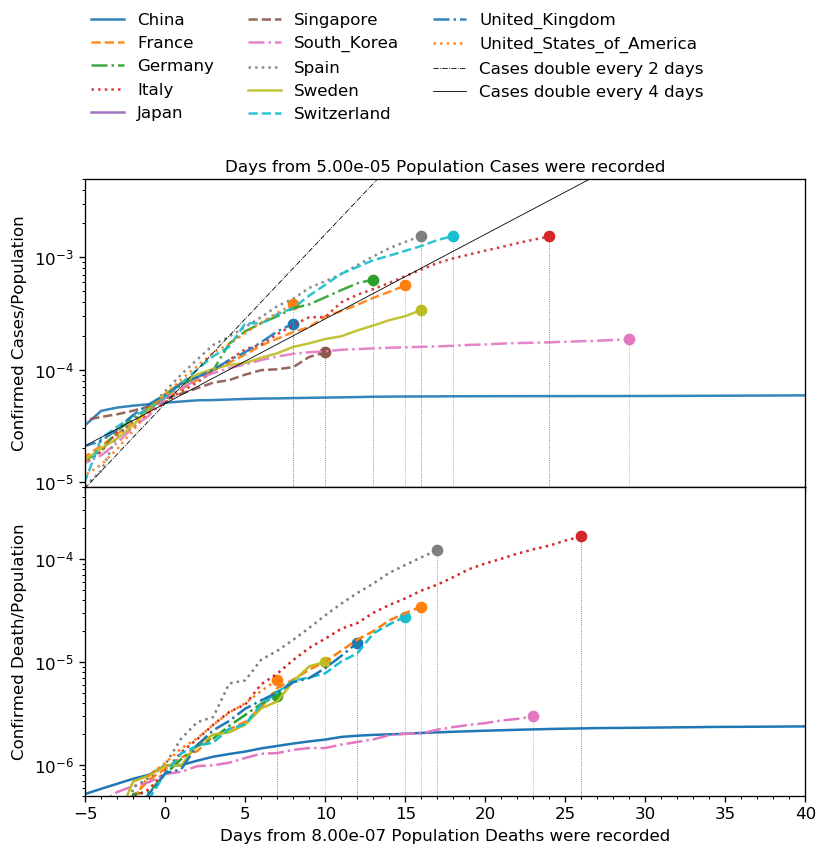

In [19]:
fig, (ax0, ax1) = plt.subplots(2,1, 
                               dpi=120, figsize=(7,6), 
                               sharex=True, gridspec_kw={'hspace': 0.})
# Set days window
day_min, day_max = -5, 40

# Barbaric index to match colors
for ind, c_data in enumerate(matches):
    # Current country name
    c_name = c_data['name']
    # Very annoying. Set up the data in numpy array, not lists.
    for key in ['t', 'cc', 'cd', 'ccn', 'cdn']:
        c_data[key] = np.array(c_data[key])
    # Get timeline
    c_t = c_data['t'] 
    # Get data for cases and death, optionally normalized
    c_dc = c_data['cc'+norm_opt]
    c_dd = c_data['cd'+norm_opt]
    # Set delay for cases and death
    delayc = c_data['delay_cc'+norm_opt] # This should have been set properly in the parsing
    delayd = c_data['delay_cd'+norm_opt] # This should have been set properly in the parsing

    #-------------------------------------------------
    # CASES
    #-------------------------------------------------
    # Log scale or not logscale? Comment to your likes
    ax0.set_yscale('log')
    # Set days window to show
    ax0.xaxis.set_label_position('top') 
    ax0.set_xlim([day_min, day_max])
    # Set Y axis according to quantity plotted
    if norm_flg:
        ax0.set_ylim([0.9e-5, 0.5e-2]) # Cases/population
        ax0.set_xlabel("Days from %.2e Population Cases were recorded"  % ccn_thold)
        ax0.set_ylabel("Confirmed Cases/Population") 
    else:
        # Set appropiate window on y
        ax0.set_ylim([90, 1.15e5]) # Adjust total number of cases in dataset!
        # Set axes labels
        ax0.set_xlabel("Days from %i cases were recorded"% cc_thold)
        ax0.set_ylabel("Confirmed Cases")  
        
    # Line at end of country timeline
    ax0.vlines(c_t[-1]-delayc, 0, c_dc[-1], 
               color=cols[ind], linestyles=":", lw=0.5)
    # Point at end of timeline
    ax0.scatter(c_t[-1]-delayc, c_dc[-1],
                c=cols[ind])
    # Plot comulative 
    ax0.plot(c_t-delayc, c_dc,
             lss[ind], 
             color=cols[ind], alpha=0.9,
             # marker=mks[ind], markeredgecolor=cols[ind], mew=0.5, markerfacecolor='none', markersize=3,
             label="%s" % c_data['name']
            )

    #-------------------------------------------------    
    # DEATHS
    #-------------------------------------------------
    # Try not to have a tick label on the top or it might overlap with the lowest from upper plot
    ax1.set_yscale('log')
    # ax.set_xlabel("Days from "+datetime.today().strftime("%A, %d %B %Y"))
    if norm_flg:
        ax1.set_ylim([5e-7, 5e-4]) # Death/population
        ax1.set_xlabel("Days from %.2e Population Deaths were recorded" % cdn_thold)
        ax1.set_ylabel("Confirmed Death/Population")
    else:
        ax1.set_ylim([1e1, 2e4]) # Total death/pop
        ax1.set_xlabel("Days from %i deaths were recorded" % cd_thold)
        ax1.set_ylabel("Confirmed Deaths")

  
    ax1.minorticks_on()
    
    ax1.vlines(c_t[-1]-delayd, 0, c_dd[-1], 
               color=cols[ind], linestyles=":", lw=0.5)
    ax1.scatter(c_t[-1]-delayd, c_dd[-1],
                c=cols[ind])
    ax1.plot(c_t-delayd, c_dd, 
             lss[ind], color=cols[ind])
    
#-------------------------------------------------
# EXPONENTIAL INCREASE
#-------------------------------------------------
expi_f1 = np.log(2)/2 # Increase factor dN/dt = expi_f N(t)
expi_f2 = np.log(2)/4
thold = cc_thold
if norm_flg:
    thold = ccn_thold
delay1 = np.log(thold)/expi_f1 # Set delay for exponential coherently with countries
delay2 = np.log(thold)/expi_f2
# Time line for expoenential
dd = np.linspace(-200, len(c_t)+100, 300)
ax0.plot(dd-delay1, np.exp(expi_f1*dd), "-.", color="black", lw=0.5, 
         label="Cases double every %i days" % (np.log(2)/expi_f1))
ax0.plot(dd-delay2, np.exp(expi_f2*dd), "-", color="black", lw=0.5, 
         label="Cases double every %i days" % (np.log(2)/expi_f2))

fig.legend(loc='lower left', bbox_to_anchor=(0.1, 1.01), ncol=3, 
           borderaxespad=0, frameon=False
          )
plt.tight_layout()
plt.savefig("desc-covid-19_at_%s.png" % today, dpi=200, bbox_inches='tight')
plt.show()

### Fit predictive power

First select a country and check how well we can fit and predict the behaviour.

Fitting should go converge most of the time.
We might be on spot for most training points as well!
But real problems begin with extrapolation: are we able to describe the evolution of the system with the analytical functions outlined above?

To test the predictive power of our fitted curves, hide some known points (day-quantity pairs) to the fitting routine and see where the estrapolated value fall compare to the measured points.

Fit 75 days, last is 15
Fit 80 days, last is 20
Fit 82 days, last is 22
Fit 84 days, last is 24
Fit 86 days, last is 26


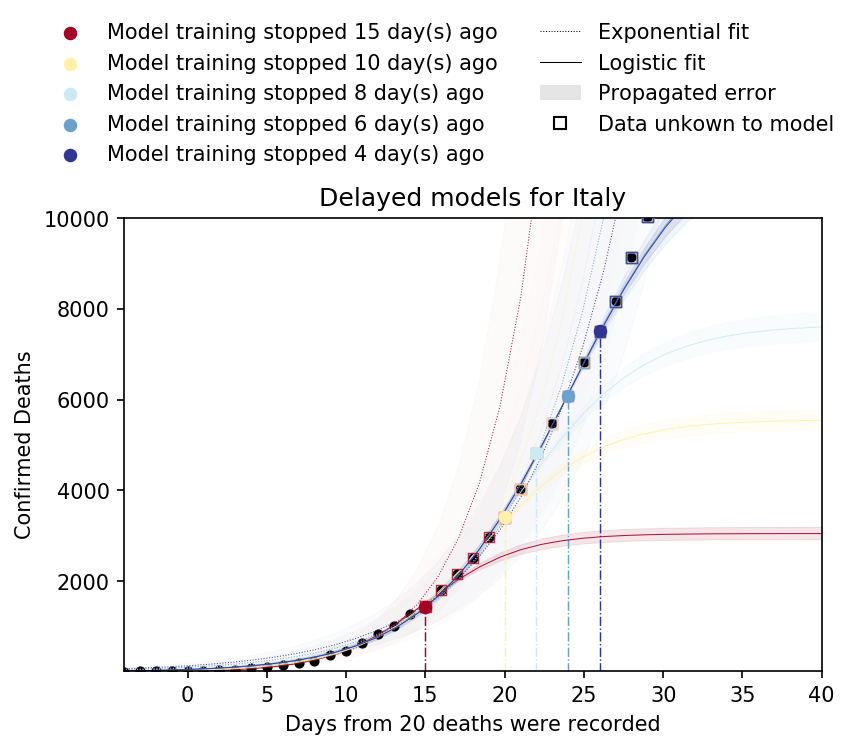

In [22]:
name = 'Italy' # Name of the test country to look up in the database.
# Get data for the conutry from the database
c_data = countries_cumul_tab.search(db_q.name == name)[0]

# Select a distant point in the past (but a valid one, depending on the country delay!)
# Select also the set of points for the delayed fit
points = [-15] + list(range(-10, -3, 2))
# Normalize points between 0-1. Need to covert to rgb using cmap
norm = matplotlib.colors.Normalize(vmin=min(points), vmax=max(points)) 
# Get a discrete set of colors from color map to match elements in plot
mapped_cols = [cmap(norm(i)) for i in points]  

# Get a canvas
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)

# Select the current data. 
# Axis ranges will be adjust accordingly, see below. Be sure it exists, or will raise KeyError.
what = 'cd'
previsions = False
# Very annoying. Set up the data
for key in ['t', 'cc', 'cd']:
    c_data[key] = np.array(c_data[key])
c_t = c_data['t'] 
c_d = c_data[what]
delay = c_data['delay_'+what] # This should have been set properly in the parsing
# Define a range for the evaluation of the analytical curve
cc_t = np.linspace(-200, max(c_t)+100, 300)

# For each delayed-fit point, get a curve. Track index for color-matching.
for ci, keep_back in enumerate(points):
    print("Fit %i days, last is %i" % (len(c_t[:keep_back]), c_t[keep_back]-delay))
    # Limit the field of view for the fit.
    c_tk, c_dk = c_t[:keep_back], c_d[:keep_back]
    
    # EXPONENTIAL FIT
    try:
        pe, cov = fit_exp_params(c_tk, c_dk)
#         print("Log params", pl)  
        # Propagate the errore using covariance of the fit
        # It's been a while since my time in the lab and fitting, but I followed this:
        # https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit
        eerr = np.sqrt(np.diagonal(cov))
        # Lower bound of the estimation
        low_b = exp_growth(cc_t, *(pe-eerr))
        # Upper bound of the estimation
        high_b = exp_growth(cc_t, *(pe+eerr))
        # Plot filled area beteween the bounds
        plt.fill_between(cc_t-delay, low_b, high_b,
                         color=mapped_cols[ci], lw=0.5, alpha=0.02)
        # Plot a line with the interpolated curve
        plt.plot(cc_t-delay, exp_growth(cc_t, *pe),
                         ":", color=mapped_cols[ci], lw=0.5, alpha=0.9)
    except RuntimeError as e:
        print("Exponential fit failed. %s is doing pretty good!  (%s)" % (name, e))
        pass
    
    # LOGISTIC FIT
    try:
        pl, cov = fit_log_params(c_tk, c_dk)
#         print("Log params", pl)  
        lerr = np.sqrt(np.diagonal(cov))
        low_b = logistic_growth(cc_t, *(pl-lerr))
        high_b = logistic_growth(cc_t, *(pl+lerr))
        plt.fill_between(cc_t-delay, low_b, high_b,
                         color=mapped_cols[ci], lw=0.5, alpha=0.1)
        plt.plot(cc_t-delay, logistic_growth(cc_t, *pl),
                 color=mapped_cols[ci], lw=0.5, alpha=0.9)
    except RuntimeError as e:
        print("Logistic fit failed. %s is still fucked  (%s)" % (name, e))
        pass

    # Last point known to the fit
    ax.scatter(c_t[keep_back]-delay, c_d[keep_back],
               s=30,  edgecolors=mapped_cols[ci], facecolors=mapped_cols[ci], alpha=1, zorder=10,
               label="Model training stopped %i day(s) ago" % (-keep_back))
    # Line from x axis
    ax.vlines(c_t[keep_back]-delay, 0, c_d[keep_back], 
              linestyle="-.", color=mapped_cols[ci], lw=0.7) 
    # Highlight data uknown to this model
    ax.scatter(c_t[keep_back:]-delay, c_d[keep_back:],
           s=25, lw=0.7,  marker="s", edgecolors=mapped_cols[ci], facecolors='none', alpha=0.8, zorder=9)

    # PREVISIONS
    if previsions:
        print("Forecast for", name)
        print("Last five days:", "%.2e "*5 % tuple(c_d[-5:]))
        print("Diff for last five days:", "%.2e "*4 % tuple(np.diff(c_d[-5:])))
        print("Today %.2e %.2e %.2e %.2e " % (c_t[-1], c_d[-1], 
                                              logistic_growth(len(c_t), *pl), 
                                              exp_growth(len(c_t), *pe)))
        low_log = logistic_growth(len(c_t)+1, *(pl-lerr))-logistic_growth(len(c_t), *(pl-lerr))
        high_log = logistic_growth(len(c_t)+1, *(pl+lerr))-logistic_growth(len(c_t), *(pl+lerr))
        low_exp = exp_growth(len(c_t)+1, *(pe-eerr))-exp_growth(len(c_t), *(pe-eerr))
        high_exp = exp_growth(len(c_t)+1, *(pe+eerr))-exp_growth(len(c_t), *(pe+eerr))
        print("Tomorrow log: %.1f new cases hi %.3g low %.3g mean %.2g" % (logistic_growth(len(c_t)+1, *pl), 
                                                high_log, low_log,  
                                                (high_log-low_log)/2))
        print("Tomorrow exp: %.3g new cases hi %.3g low %.3g mean %.2g" % (exp_growth(len(c_t)+1, *pe), 
                                                 high_exp, low_exp,  
                                                (high_exp-low_exp)/2))
        print("In between distros: %.4g" % (((high_exp-low_exp)/2+(high_log-low_log)/2)/2))
        print()

ax.scatter(c_t-delay, c_d,
           s=15, c='black', alpha=1)

# Log scale or not logscale? Comment if you want it linear
# You might want to adjust the range if you go for linear.
# ax.set_yscale('log')
# Set days window to show
ax.set_xlim([-4, 40])
# ax.set_xlabel("Days from "+datetime.today().strftime("%A, %d %B %Y"))
# Set Y axis according to quantity plotted
if what == 'cc':
    # Set appropiate window on y
    ax.set_ylim([90, 1.1e5]) # Adjust total number of cases in dataset!
    # Set axes labels
    ax.set_xlabel("Days from %i cases were recorded" % cc_thold)
    ax.set_ylabel("Confirmed Cases")
elif what == 'cd':
    ax.set_ylim([2e1, 1e4]) # Total death/pop
    ax.set_xlabel("Days from %i deaths were recorded" % cd_thold)
    ax.set_ylabel("Confirmed Deaths")
elif what == 'ccn':
    ax.set_ylim([1e-5, 1e-2]) # Cases/population
    ax.set_xlabel("Days from %.2e Poppulation Cases were recorded" % ccn_thold)
    ax.set_ylabel("Confirmed Cases/Population")
elif what == 'cdn':
    ax.set_ylim([5e-7, 5e-4]) # Death/population
    ax.set_xlabel("Days from %.2e Poppulation Deaths were recorded" % cdn_thold)
    ax.set_ylabel("Confirmed Death/Population")
else:
    raise ValueError("What did you say about my mother? Select a proper case.")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='black', linestyle=":", lw=0.5, label='Exponential fit'),
                   Line2D([0], [0], color='black', linestyle="-", lw=0.5, label='Logistic fit'),
                   Patch(facecolor='black', edgecolor=None, alpha=0.1,
                         label='Propagated error'),
                   Line2D([0], [0], marker='s',
                          mec="black", mfc='none', lw=0.0, label='Data unkown to model')
                  ]
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles+legend_elements)
ax.legend(handles=handles+legend_elements, 
           loc='lower left', bbox_to_anchor=(-0.12, 1.1), ncol=2, 
           borderaxespad=0, frameon=False)
ax.set_title("Delayed models for %s" % name) #,  bbox_to_anchor=(-0.12, 1.03))
plt.savefig("pred_power-covid-19_at_%s.png" % today, dpi=200, bbox_inches='tight')
plt.show()

### Fit data and forecast

Now the you know you shouldn't trust the fit too much, let's do it on a bunch of countries and try to predict the behaviour.
This is basically the code from the previous cell (with a single "optimal" ```keep_back``` value) applied to different countries.

Note: it would be nice to have the "experimental" uncertanty on each datapoint.
We could propagate it to prediciton and have a more meaningful confidence interval.

First of all select a subset of countries. Plotting dozens of countries can be overwhelming.

In [23]:
countries = ['Italy', 'Germany', 'United_Kingdom', 'Spain']

In [24]:
# Select the current data. 
# Axis ranges will be adjust accordingly, see below. Be sure it exists, or will raise KeyError.
what = 'cdn'
previsions = False
fit_exp = True
fit_log = True

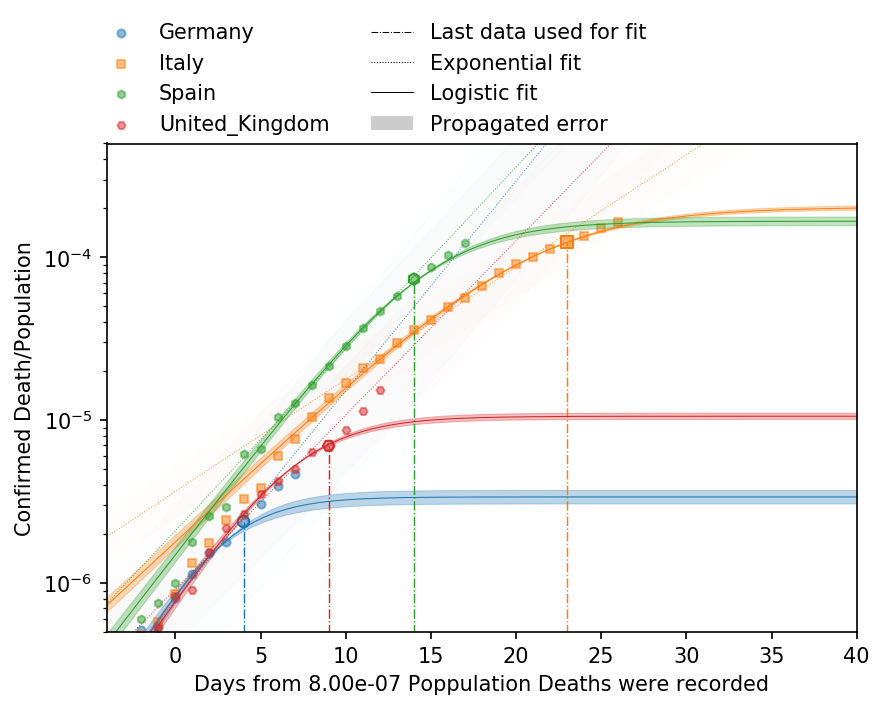

In [25]:
# Set up a canvas from matplotlib
fig = plt.figure()
fig.set_dpi(150) # Resolution of the figure. Indirectly set size as well.
ax = fig.add_subplot(111)

# Hide some days from the "model training", i.e. the fitting...
keep_back = -4

# Keep track of the index, to match the color
for ci, c_data in enumerate(countries_cumul_tab.search(db_q.name.one_of(countries))):
    c_name = c_data['name']
    # Very annoying. Set up the data
    for key in ['t', 'cc', 'cd', 'ccn', 'cdn']:
        c_data[key] = np.array(c_data[key])
    c_t = c_data['t'] 
    c_d = c_data[what]
    delay = c_data['delay_'+what] # This should have been set properly in the parsing
    # Define a range for the evaluation of the analytical curve
    cc_t = np.linspace(min(c_t), max(c_t)+100, 300)

    # EXPONENTIAL FIT
    if fit_exp:
        try:
            pe, cov = fit_exp_params(c_t[:(keep_back)], c_d[:(keep_back)])
            eerr = np.sqrt(np.diagonal(cov))
            low_b = exp_growth(cc_t, *(pe-eerr))
            high_b = exp_growth(cc_t, *(pe+eerr))
            plt.fill_between(cc_t-delay, low_b, high_b,
                             color=cols[ci], lw=0.5, alpha=0.01)
            plt.plot(cc_t-delay, exp_growth(cc_t, *pe),
                             ":", color=cols[ci], lw=0.5, alpha=0.8)
        except (RuntimeError, ValueError, OverflowError) as e:
            print("Exponential fit failed. %s is doing pretty well (%s)" % (c_name, e))
            pass

    # LOGISTIC FIT
    if fit_log:
        try:
            pl, cov = fit_log_params(c_t[:keep_back], c_d[:keep_back])
            lerr = np.sqrt(np.diagonal(cov))
            low_b = logistic_growth(cc_t, *(pl-lerr))
            high_b = logistic_growth(cc_t, *(pl+lerr))
            plt.fill_between(cc_t-delay, low_b, high_b,
                             color=cols[ci], lw=0.5, alpha=0.3)
            plt.plot(cc_t-delay, logistic_growth(cc_t, *pl),
                             color=cols[ci], lw=0.5)
        except (RuntimeError, ValueError, OverflowError) as e:
            print("Logistic fit failed. %s is still fucked (%s)" % (c_name, e))
            pass

    # PREVISIONS
    if previsions and fit_exp and fit_log:
        print("Forecast for", c_name)
        print("Last five days:", "%.2e "*5 % tuple(c_d[-5:]))
        print("Diff for last five days:", "%.2e "*4 % tuple(np.diff(c_d[-5:])))
        print("Today %.2e %.2e %.2e %.2e " % (c_t[-1], c_d[-1], 
                                              logistic_growth(len(c_t), *pl), 
                                              exp_growth(len(c_t), *pe)))
        low_log = logistic_growth(len(c_t)+1, *(pl-lerr))-logistic_growth(len(c_t), *(pl-lerr))
        high_log = logistic_growth(len(c_t)+1, *(pl+lerr))-logistic_growth(len(c_t), *(pl+lerr))
        low_exp = exp_growth(len(c_t)+1, *(pe-eerr))-exp_growth(len(c_t), *(pe-eerr))
        high_exp = exp_growth(len(c_t)+1, *(pe+eerr))-exp_growth(len(c_t), *(pe+eerr))
        print("Tomorrow log: %.1f new cases hi %.3g low %.3g mean %.2g" % (logistic_growth(len(c_t)+1, *pl), 
                                                high_log, low_log,  
                                                (high_log-low_log)/2))
        print("Tomorrow exp: %.3g new cases hi %.3g low %.3g mean %.2g" % (exp_growth(len(c_t)+1, *pe), 
                                                 high_exp, low_exp,  
                                                (high_exp-low_exp)/2))
        print("In between distros: %.4g" % (((high_exp-low_exp)/2+(high_log-low_log)/2)/2))
        print()
    
    # ACTUAL DATA
    ax.scatter(c_t-delay, c_d,
               label=c_name,
               marker=mks[ci],
               s=15,  edgecolors=cols[ci], facecolors=cols[ci], alpha=0.5)
#     ax.plot(c_t-delay, c_d,
#             '-',
#             marker=mks[ind], markeredgecolor=cols[ind], mew=0.5, markerfacecolor='none', markersize=3,
#             color=cols[ci], lw=0.5)

    # Highlight last point used for fit
    ax.scatter(c_t[keep_back]-delay, c_d[keep_back],
               marker=mks[ci],
               s=30,  edgecolors=cols[ci], facecolors='none', alpha=1)
    ax.vlines(c_t[keep_back]-delay, 0, c_d[keep_back],
              linestyle="-.", color=cols[ci], lw=0.7)
    
    # Log scale or not logscale? Comment to your likes
    ax.set_yscale('log')
    # Set days window to show
    ax.set_xlim([-4, 40])
    # ax.set_xlabel("Days from "+datetime.today().strftime("%A, %d %B %Y"))
    # Set Y axis according to quantity plotted
    if what == 'cc':
        # Set appropiate window on y
        ax.set_ylim([90, 1.1e5]) # Adjust total number of cases in dataset!
        # Set axes labels
        ax.set_xlabel("Days from %i cases were recorded" % cc_thold)
        ax.set_ylabel("Confirmed Cases")
    elif what == 'cd':
        ax.set_ylim([2e1, 1e4]) # Total death/pop
        ax.set_xlabel("Days from %i deaths were recorded" % cd_thold)
        ax.set_ylabel("Confirmed Deaths")
    elif what == 'ccn':
        ax.set_ylim([1e-5, 1e-2]) # Cases/population
        ax.set_xlabel("Days from %.2e Poppulation Cases were recorded" % ccn_thold)
        ax.set_ylabel("Confirmed Cases/Population")
    elif what == 'cdn':
        ax.set_ylim([5e-7, 5e-4]) # Death/population
        ax.set_xlabel("Days from %.2e Poppulation Deaths were recorded" % cdn_thold)
        ax.set_ylabel("Confirmed Death/Population")
    else:
        raise ValueError("What did you say about my mother? Select a proper case.")

# A bit of a mess to do the legend properly if you fitted: add custom entries to show what the lines are
if fit_exp or fit_log:
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='black', linestyle="-.", lw=0.5, 
                              label='Last data used for fit'), 
                       Line2D([0], [0], color='black', linestyle=":", lw=0.5, 
                              label='Exponential fit'),
                       Line2D([0], [0], color='black', linestyle="-", lw=0.5, 
                              label='Logistic fit'),
                       Patch(facecolor='black', edgecolor=None, alpha=0.2,
                             label='Propagated error')]
# If no fits, just leave it empty
else:
    legend_elements = []
handles, labels = ax.get_legend_handles_labels()
# Legend is big, put t outside the plot. Distribute it on ncol columns 
ax.legend(handles=handles+legend_elements, 
           loc='lower left', bbox_to_anchor=(-0.02, 1.), ncol=2, 
           borderaxespad=0, frameon=False)

# Use tightlayout to be sure nothing is cropped.
plt.savefig("fit-covid-19_at_%s.png" % today, dpi=200, bbox_inches='tight')
plt.tight_layout()
plt.show()

Simple, stupid estimation according to optimistic factors if BJ goes for "herd immunity", whatever that is without a vaccine.

In [26]:
import locale
locale.setlocale(locale.LC_ALL, '')

pop = 66e6
infected_f = 0.5
critical_f = 0.08
untreated_critical = 0.1 # With no response
dead_f = 0.005

print("Let's assume no containment measure whatsoever.")
print("Assuming an infection fraction of %.1f%%, a critical fraction of %.1f%% and death reate of %.1f%%" % (infected_f*100, critical_f*100, dead_f*100))
print("""On a population of %.1e inahabitants, %.1e (%.2f%%) would get infected.""" % (pop, 
                                                                                       pop*infected_f, 
                                                                                       infected_f*100))
print("Of these, {:,} ({:.2f}%) will get die in normal conditions.".format(pop*infected_f*dead_f, 
                                                                           infected_f*dead_f*100).replace(",", " "))
print("Of the infected population, {:,} ({:.2f}%) will get critical.".format(pop*infected_f*critical_f, 
                                                                             infected_f*critical_f*100).replace(",", " "))
print("""Assuming of critical population {:.2f}% of these won't find space in ICU, additional {:,} will die because of health care system, not virus.""".format(untreated_critical*100, pop*infected_f*critical_f*untreated_critical).replace(",", " "))
print("This adds up to {:,} death".format(pop*infected_f*critical_f*untreated_critical+pop*infected_f*dead_f).replace(",", " "))

Let's assume no containment measure whatsoever.
Assuming an infection fraction of 50.0%, a critical fraction of 8.0% and death reate of 0.5%
On a population of 6.6e+07 inahabitants, 3.3e+07 (50.00%) would get infected.
Of these  165 000.0 (0.25%) will get die in normal conditions.
Of the infected population  2 640 000.0 (4.00%) will get critical.
Assuming of critical population 10.00% of these won't find space in ICU  additional 264 000.0 will die because of health care system  not virus.
This adds up to 429 000.0 death


Let's have a wordwide spirit and see how humanity is doing, by plotting data from all countries.

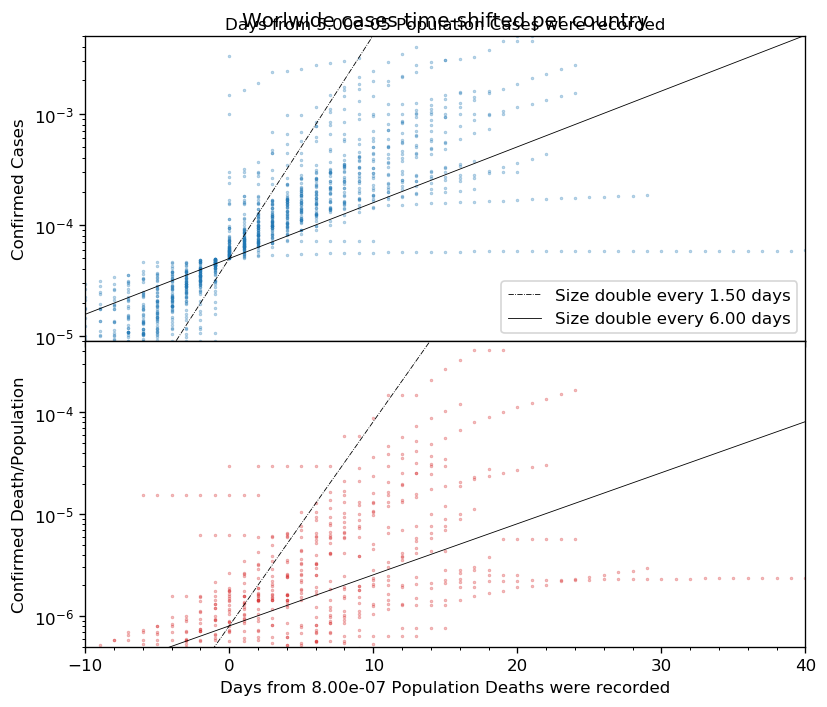

In [31]:
norm_opt = 'n'
fig, (ax0, ax1) = plt.subplots(2,1, 
                               dpi=120, figsize=(7,6), 
                               sharex=True, gridspec_kw={'hspace': 0.})
# Set days window
day_min, day_max = -10, 40

for c_data in countries_cumul_tab.all():
    # Current country name
    c_name = c_data['name']
    # Very annoying. Set up the data in numpy array, not lists.
    for key in ['t', 'cc', 'cd', 'ccn', 'cdn']:
        c_data[key] = np.array(c_data[key])
    # Get timeline
    c_t = c_data['t'] 
    # Get data for cases and death, optionally normalized
    c_dc = c_data['cc'+norm_opt]
    c_dd = c_data['cd'+norm_opt]
    # Set delay for cases and death
    delayc = c_data['delay_cc'+norm_opt] # This should have been set properly in the parsing
    delayd = c_data['delay_cd'+norm_opt] # This should have been set properly in the parsing

    #-------------------------------------------------
    # CASES
    #-------------------------------------------------
    # Log scale or not logscale? Comment to your likes
    ax0.set_yscale('log')
    # Set days window to show
    ax0.xaxis.set_label_position('top') 
    ax0.set_xlim([day_min, day_max])
    # Set Y axis according to quantity plotted
    ax0.set_ylim([0.9e-5, 0.5e-2]) # Cases/population
    ax0.set_xlabel("Days from %.2e Population Cases were recorded"  % ccn_thold)
    ax0.set_ylabel("Confirmed Cases/Population") 
    ax0.set_ylabel("Confirmed Cases")  
        
    # Plot comulative 
    ax0.scatter(c_t-delayc, c_dc,
                alpha=0.3, s=10,
                marker='.', edgecolor='tab:blue', lw=0.5, facecolor='tab:blue',
                )

    #-------------------------------------------------    
    # DEATHS
    #-------------------------------------------------
    # Try not to have a tick label on the top or it might overlap with the lowest from upper plot
    ax1.set_yscale('log')
    # ax.set_xlabel("Days from "+datetime.today().strftime("%A, %d %B %Y"))
    ax1.set_ylim([5e-7, 5e-4]) # Death/population
    ax1.set_xlabel("Days from %.2e Population Deaths were recorded" % cdn_thold)
    ax1.set_ylabel("Confirmed Death/Population")
    ax1.minorticks_on()
    
    # Plot comulative 
    ax1.scatter(c_t-delayc, c_dd,
                alpha=0.3, s=10,
                marker='.', edgecolor='tab:red', lw=0.5, facecolor='tab:red',
                )
    
#-------------------------------------------------
# EXPONENTIAL INCREASE
#-------------------------------------------------
expi_f1 = np.log(2)/1.5 # Increase factor dN/dt = expi_f N(t)
expi_f2 = np.log(2)/6
thold = ccn_thold
delay1 = np.log(thold)/expi_f1 # Set delay for exponential coherently with countries
delay2 = np.log(thold)/expi_f2
# Time line for expoenential
dd = np.linspace(-200, len(c_t)+100, 300)
ax0.plot(dd-delay1, np.exp(expi_f1*dd), "-.", color="black", lw=0.5, 
         label="Size double every %.2f days" % (np.log(2)/expi_f1))
ax0.plot(dd-delay2, np.exp(expi_f2*dd), "-", color="black", lw=0.5, 
         label="Size double every %.2f days" % (np.log(2)/expi_f2))

thold = cdn_thold
delay1 = np.log(thold)/expi_f1 # Set delay for exponential coherently with countries
delay2 = np.log(thold)/expi_f2
ax1.plot(dd-delay1, np.exp(expi_f1*dd), "-.", color="black", lw=0.5)
ax1.plot(dd-delay2, np.exp(expi_f2*dd), "-", color="black", lw=0.5)

ax0.legend(loc='lower right')
ax0.set_title("Worlwide cases time-shifted per country")

plt.tight_layout()
plt.savefig("world-desc-covid-19_at_%s.png" % today, dpi=200, bbox_inches='tight')
plt.show()

Not very informative. We should probably divede between a saturating Far East (that learnt from 2003 SARS) and an unprepared West (that hopefully will know better next time...)

I strongly suspect that the vertical line at 0 are tiny countries that basically hit (and pass by far) the threshold as soon as they started testing.